<a href="https://colab.research.google.com/github/JoseTobon/AI_Notebooks/blob/main/CalistaAesthetics_AP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Calista-AI Approach 2 - MobileNet**
Usage of pretrained models

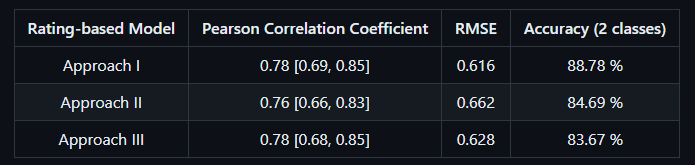


In [2]:
# Cloning of repo
!git clone https://github.com/calista-ai/website-aesthetics-research.git

# Downloading of datasets
!cd website-aesthetics-research/ && git submodule update --init

Cloning into 'website-aesthetics-research'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 100 (delta 38), reused 80 (delta 23), pack-reused 0
Receiving objects: 100% (100/100), 35.12 KiB | 11.71 MiB/s, done.
Resolving deltas: 100% (38/38), done.
Submodule 'datasets' (https://github.com/calista-ai/website-aesthetics-datasets.git) registered for path 'datasets'
Cloning into '/content/website-aesthetics-research/datasets'...
Submodule path 'datasets': checked out '276babac8308628f47e17d6e64feda9f23d89276'


## **Rating-based approach II**

Description: In this approach, the model was trained using the mean value of the user ratings for each website. The model's output is an aesthetics score on the scale 1-9.

Transfer-learning: Flickr-Style was used as a base network

In [3]:
# Get Gdown for downloading large drive files
!pip install gdown
# Donwload of pretrained model based on approach 1

!cd website-aesthetics-research/pretrained-models/ && gdown https://drive.google.com/uc?id=14YD5aNajaJDU9cCVNdz9KLbupO9pVcpT -O flickr_style.h5

Downloading...
From (original): https://drive.google.com/uc?id=14YD5aNajaJDU9cCVNdz9KLbupO9pVcpT
From (redirected): https://drive.google.com/uc?id=14YD5aNajaJDU9cCVNdz9KLbupO9pVcpT&confirm=t&uuid=eae2cc7c-5b24-43ea-a242-72333476a147
To: /content/website-aesthetics-research/pretrained-models/flickr_style.h5
100% 228M/228M [00:07<00:00, 29.7MB/s]


In [4]:
# Installation of dependencies
!pip install -r website-aesthetics-research/requirements.txt

ERROR: Could not find a version that satisfies the requirement tensorflow==1.14.0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.11.1, 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1)
ERROR: No matching distribution found for tensorflow==1.14.0


In [5]:
!pip install unrar
!unrar x 'website-aesthetics-research/datasets/rating-based-dataset/data/ae_only_unambiguous_1000.rar'


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from website-aesthetics-research/datasets/rating-based-dataset/data/ae_only_unambiguous_1000.rar

Extracting  ae_only_unambiguous_1000.csv                                   0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87% 88% 89% 90% 91% 9

Import training and testing data.

{train, test}_images: contains the path of each image

{train, test}_scores: contains the user ratings of each image

In [6]:
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

data_folder = 'website-aesthetics-research/datasets/rating-based-dataset/'

scores_data = pd.read_csv("ae_only_unambiguous_1000.csv", low_memory=False)

_images = scores_data['website'].unique()
_scores = scores_data.groupby('website')['mean_response'].apply(list)

del scores_data

all_images = []
scores = []
images_path = data_folder + 'preprocess/resized'

for image in _images:

  # english websites
  if 'english' in image:
    all_images.append(images_path + '/english_resized/' + image[8:] + '.png')
    scores.append(_scores[image])

  # foreign websites
  if 'foreign' in image:
    all_images.append(images_path + '/foreign_resized/' + image[8:] + '.png')
    scores.append(_scores[image])

print('Total number of images: %d' % len(all_images))


test_data_path = data_folder + 'preprocess/test_list.csv'

def get_scores(scores_path):

    images = []
    scores = []

    with open(scores_path) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0

        for row in csv_reader:
            if line_count == 0:

                line_count += 1
            else:

                scores.append(float(row[1]))
                line_count += 1
                image_name = row[0]

                images.append(images_path + image_name)

    return (images, scores)

test_images_names, gt_scores = get_scores(test_data_path)

train_images =[]
train_scores =[]

test_images = test_images_names
test_scores = [[]] * len(test_images)

for i in range(0, len(all_images)):
  if all_images[i] in test_images_names:

    pos = test_images_names.index(all_images[i])

    test_scores[pos] = scores[i]
  else:
    train_images.append(all_images[i])
    train_scores.append(scores[i])

Total number of images: 398


In [7]:
# Shuffle the training data

import random

# np.random.seed(2000)

temp = list(zip(train_images, train_scores))
random.shuffle(temp)

train_images, train_scores = zip(*temp)

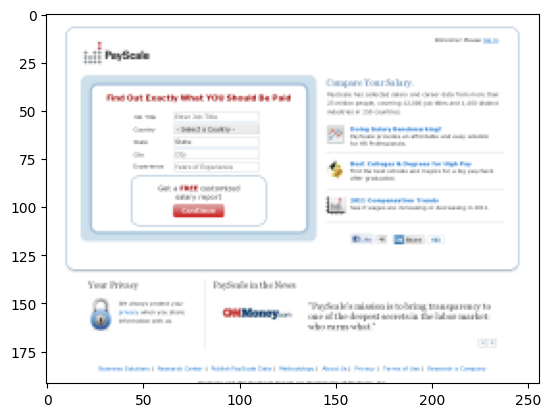

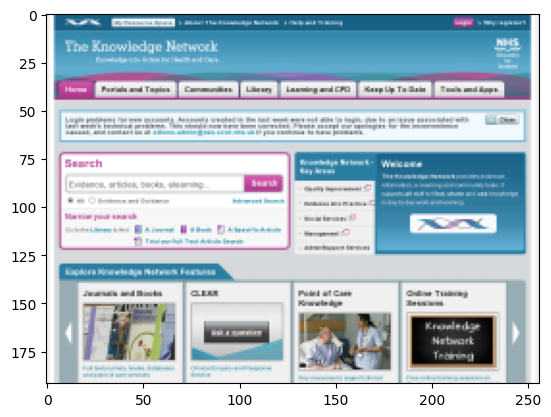

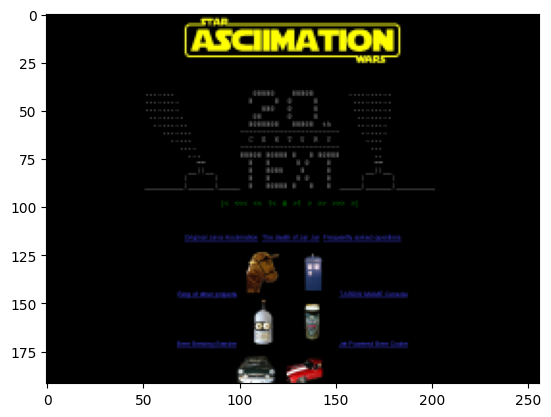

In [8]:
# Displaying images

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.image as mping
for ima in train_images[0:3]:
  img = mping.imread(ima)
  imgplot = plt.imshow(img)
  plt.show()

In [18]:
# Transform to numpy arrays

import cv2

width = 256
height = 192
channels = 3

def read_and_process_images(list_of_images):
  X = []

  for image in list_of_images:

    #images are already resized
    #X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (width, height),
                         #interpolation=cv2.INTER_AREA))
    X.append(cv2.imread(image, cv2.IMREAD_COLOR))


  return X


X_train = np.array(read_and_process_images(train_images))
X_val = np.array(read_and_process_images(test_images))

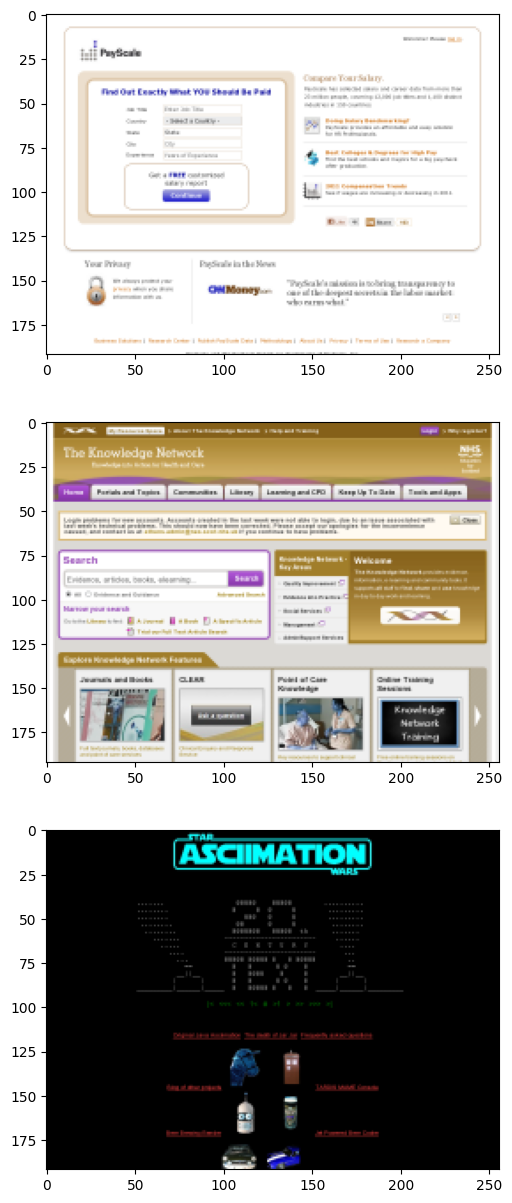

In [19]:
plt.figure(figsize=(25,15))
columns = 3

for i in range(columns):
  plt.subplot(columns, 1, i+1)
  plt.imshow(X_train[i])

In [20]:
bins = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]
score_values = np.array([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0])

y_train = []

for i in range(0, len(train_scores)):
  y_temp = np.histogram(train_scores[i], bins=bins)[0]
  y_train.append(y_temp / len(train_scores[i]))
  del y_temp

y_train = np.array(y_train)

y_val = []

for i in range(0, len(test_scores)):
  y_temp = np.histogram(test_scores[i], bins=bins)[0]
  y_val.append(y_temp / len(test_scores[i]))
  del y_temp

y_val = np.array(y_val)


In [21]:
ntrain = len(X_train)
nval = len(X_val)

print('Shape of X_train is: ', X_train.shape)
print('Shape of X_val is: ', X_val.shape)
print('Shape of y_train is: ', y_train.shape)
print('Shape of y_val is: ', y_val.shape)

Shape of X_train is:  (300, 192, 256, 3)
Shape of X_val is:  (98, 192, 256, 3)
Shape of y_train is:  (300, 9)
Shape of y_val is:  (98, 9)


Get weights from previously downloaded pre-trained model (flickr style)

In [22]:
from keras.applications.mobilenet import MobileNet
from keras import optimizers
from keras import regularizers
from keras.layers import GlobalMaxPooling2D, Dense, Dropout, Flatten
from keras.models import Model

input_shape = X_train[0].shape

base_model = MobileNet(include_top=False, weights='imagenet', pooling='avg', input_shape=input_shape)

x = base_model.output
x = Dropout(0.6)(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.load_weights('website-aesthetics-research/pretrained-models/mobilenet_weights.h5')

model.layers.pop()
outputs = Dense(9, activation='softmax')(model.layers[-1].output)
model = Model(inputs=model.input, outputs=outputs)

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 192, 256, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 96, 128, 32)       864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 96, 128, 32)       128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 96, 128, 32)       0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 96, 128, 32)       288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 96, 128, 32)       128 

In [23]:
from keras import backend as K

def earth_mover_loss(y_true, y_pred):
    cdf_ytrue = K.cumsum(y_true, axis=-1)
    cdf_ypred = K.cumsum(y_pred, axis=-1)
    samplewise_emd = K.sqrt(K.mean(K.square(K.abs(cdf_ytrue - cdf_ypred)), axis=-1))
    return K.mean(samplewise_emd)


In [24]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32

train_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)


In [25]:
epochs = 95
decay = 1e-4
base_lr = 0.005

sgd = tf.keras.optimizers.SGD(learning_rate=base_lr, momentum=0.9, nesterov=True)
model.compile(loss=earth_mover_loss, optimizer=sgd, metrics=[earth_mover_loss])


In [26]:
# Train the model
history = model.fit_generator(train_generator,
                             steps_per_epoch = ntrain // batch_size,
                             epochs = epochs,
                             validation_data=val_generator,
                             validation_steps=nval // batch_size)

Epoch 1/95


<ipython-input-26-a0610d8dc909>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


9/9 [==============================] - 23s 357ms/step - loss: 0.1539 - earth_mover_loss: 0.1549 - val_loss: 0.1429 - val_earth_mover_loss: 0.1429
Epoch 2/95
9/9 [==============================] - 1s 118ms/step - loss: 0.1508 - earth_mover_loss: 0.1502 - val_loss: 0.1429 - val_earth_mover_loss: 0.1429
Epoch 3/95
9/9 [==============================] - 1s 145ms/step - loss: 0.1478 - earth_mover_loss: 0.1500 - val_loss: 0.1404 - val_earth_mover_loss: 0.1404
Epoch 4/95
9/9 [==============================] - 1s 124ms/step - loss: 0.1461 - earth_mover_loss: 0.1468 - val_loss: 0.1401 - val_earth_mover_loss: 0.1401
Epoch 5/95
9/9 [==============================] - 1s 117ms/step - loss: 0.1461 - earth_mover_loss: 0.1458 - val_loss: 0.1383 - val_earth_mover_loss: 0.1383
Epoch 6/95
9/9 [==============================] - 1s 116ms/step - loss: 0.1464 - earth_mover_loss: 0.1472 - val_loss: 0.1390 - val_earth_mover_loss: 0.1390
Epoch 7/95
9/9 [==============================] - 1s 116ms/step - loss: 0.

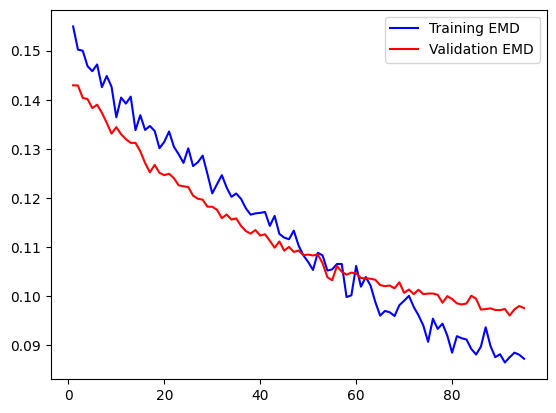

In [27]:
# Displaying learning curve


emd = history.history["earth_mover_loss"]
val_emd = history.history["val_earth_mover_loss"]

epochs_x = range(1, len(emd) + 1)

plt.plot(epochs_x, emd, 'b', label='Training EMD')
plt.plot(epochs_x, val_emd, 'r', label='Validation EMD')

plt.legend()

In [28]:
from scipy import stats

def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''
    N = len(x)
    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(N-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

In [29]:
# To predict scores on the first 10 images
predictions = []

X_val = X_val / 255.0

for img in X_val:
  img = img.reshape(1, 192, 256, 3)
  pred = model.predict(img)

  predictions.append(float(np.sum(pred[0] * score_values)))

gt_scores = np.array(gt_scores)
predictions = np.array(predictions)

1/1 [==============================] - 0s 18ms/step


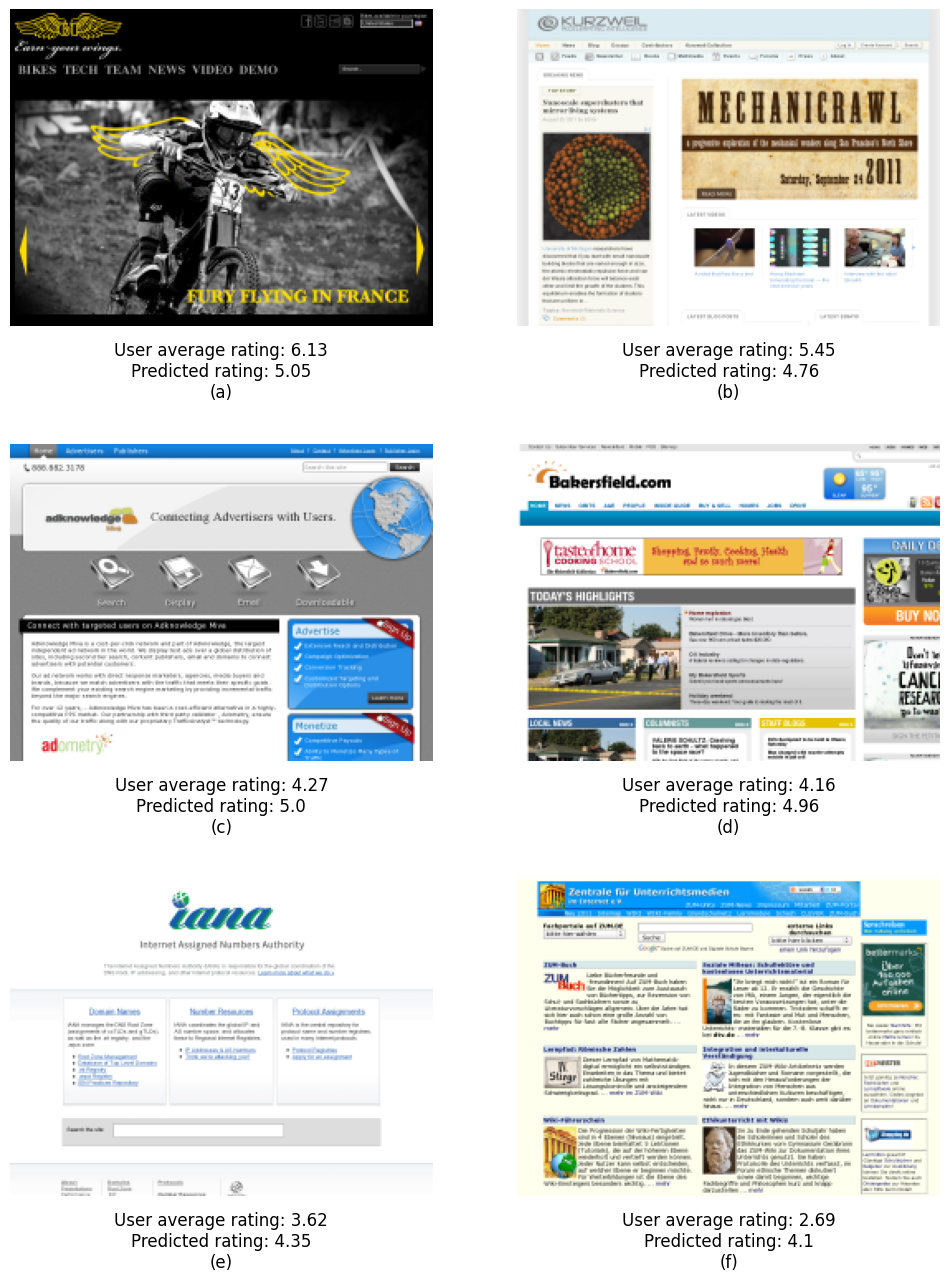

In [30]:
image_ids = [87, 45, 49, 94, 14, 83] # test image IDs sorted in descending order according to the website's aesthetics level

fig = plt.figure(figsize=(12, 16))
i = 1
for id in image_ids:
  if 'english' in test_images[id]:
    path = images_path + '/english_resized/' + test_images[id].rsplit('/', 1)[1]
  else:
    path = images_path + '/foreign_resized/' + test_images[id].rsplit('/', 1)[1]

  plt.subplot(len(image_ids)//2, 2, i)
  img = mping.imread(path)
  plt.title('User average rating: ' + str(np.round(gt_scores[id],2)) + '\nPredicted rating: ' + str(np.round(predictions[id],2)) + '\n(' + chr(97+i-1) + ')', y=-0.25)
  plt.axis('off')
  plt.imshow(img)

  i += 1

plt.show()

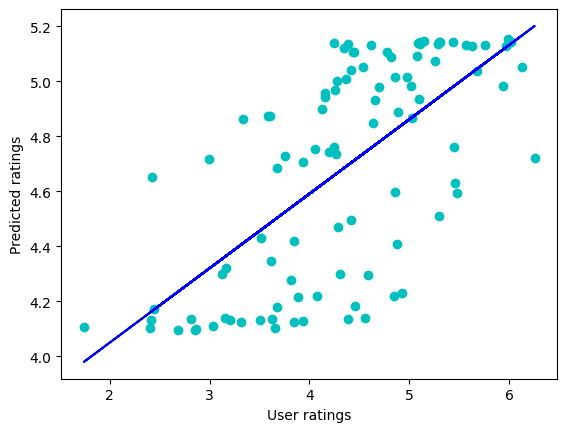

In [31]:
# Scatter plot for groundtruth and the predictions

from numpy.polynomial.polynomial import polyfit
b, m = polyfit(gt_scores, predictions, 1)

fig = plt.figure()
plt.scatter(gt_scores, predictions, c='c')
plt.plot(gt_scores, b + m * gt_scores, '-', c='b')
plt.xlabel('User ratings')
plt.ylabel('Predicted ratings')

plt.show()

In [32]:
from sklearn.metrics import mean_squared_error
from math import sqrt

corr, p, lo, hi = pearsonr_ci(gt_scores, predictions)
print('Pearsons correlation: r=%.2f, p=%.2e, CI=[%.2f, %.2f]' % (corr, p, lo, hi))
rmse_test = sqrt(mean_squared_error(gt_scores, predictions))
print('RMSE: %.3f' % rmse_test)


Pearsons correlation: r=0.66, p=1.13e-13, CI=[0.53, 0.76]
RMSE: 0.832


<ipython-input-33-be61a24fe270>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(gt_scores, bins=bins, label='User ratings')
<ipython-input-33-be61a24fe270>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(predictions, bins=bins, label='Predicted ratings')


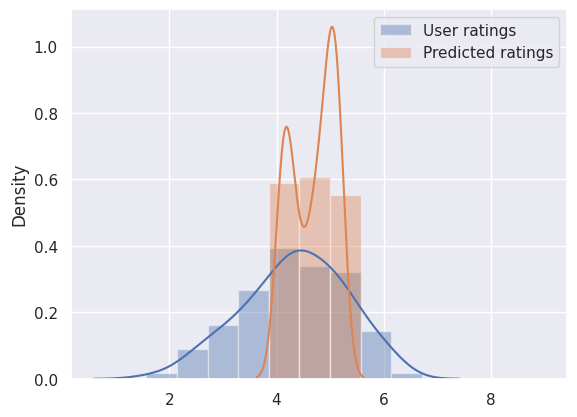

In [33]:
import seaborn as sns

fig = plt.figure()
sns.set(color_codes=True)

bins = np.linspace(1, 9, num=15)

sns.distplot(gt_scores, bins=bins, label='User ratings')

sns.distplot(predictions, bins=bins, label='Predicted ratings')

plt.legend()

plt.show()

In [ ]:
!pip install grad-cam

In [44]:
import cv2
import numpy as np
from PIL import Image
import tensorflow as tf
import tensorflow.keras as K
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.models import Model


def VizGradCAM(model, image, interpolant=0.5, plot_results=True):
    """VizGradCAM - Displays GradCAM based on Keras / TensorFlow models
    using the gradients from the last convolutional layer. This function
    should work with all Keras Application listed here:
    https://keras.io/api/applications/

    Parameters:
    model (keras.model): Compiled Model with Weights Loaded
    image: Image to Perform Inference On
    plot_results (boolean): True - Function Plots using PLT
                            False - Returns Heatmap Array

    Returns:
    Heatmap Array?
    """
    # Sanity Check
    assert (
        interpolant > 0 and interpolant < 1
    ), "Heatmap Interpolation Must Be Between 0 - 1"

    last_conv_layer = next(
        x for x in model.layers[::-1] if isinstance(x, K.layers.Conv2D)
    )
    target_layer = model.get_layer(last_conv_layer.name)

    original_img = image
    img = np.expand_dims(original_img, axis=0)
    prediction = model.predict(img)

    # Obtain Prediction Index
    prediction_idx = np.argmax(prediction)

    # Compute Gradient of Top Predicted Class
    with tf.GradientTape() as tape:
        gradient_model = Model([model.inputs], [target_layer.output, model.output])
        conv2d_out, prediction = gradient_model(img)
        # Obtain the Prediction Loss
        loss = prediction[:, prediction_idx]

    # Gradient() computes the gradient using operations recorded
    # in context of this tape
    gradients = tape.gradient(loss, conv2d_out)

    # Obtain the Output from Shape [1 x H x W x CHANNEL] -> [H x W x CHANNEL]
    output = conv2d_out[0]

    # Obtain Depthwise Mean
    weights = tf.reduce_mean(gradients[0], axis=(0, 1))

    # Create a 7x7 Map for Aggregation
    activation_map = np.zeros(output.shape[0:2], dtype=np.float32)

    # Multiply Weights with Every Layer
    for idx, weight in enumerate(weights):
        activation_map += weight * output[:, :, idx]

    # Resize to Size of Image
    activation_map = cv2.resize(
        activation_map.numpy(), (original_img.shape[1], original_img.shape[0])
    )

    # Ensure No Negative Numbers
    activation_map = np.maximum(activation_map, 0)

    # Convert Class Activation Map to 0 - 255
    activation_map = (activation_map - activation_map.min()) / (
        activation_map.max() - activation_map.min()
    )
    activation_map = np.uint8(255 * activation_map)

    # Convert to Heatmap
    heatmap = cv2.applyColorMap(activation_map, cv2.COLORMAP_JET)

    # Superimpose Heatmap on Image Data
    original_img = np.uint8(
        (original_img - original_img.min())
        / (original_img.max() - original_img.min())
        * 255
    )

    cvt_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Enlarge Plot
    plt.rcParams["figure.dpi"] = 100

    if plot_results == True:
        plt.imshow(
            np.uint8(original_img * interpolant + cvt_heatmap * (1 - interpolant))
        )
    else:
        return cvt_heatmap



# Importa la función VizGradCam y img_to_array
import gradcam
from gradcam import VizGradCAM
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img

# Carga tu imagen favorita
test_img = X_val[1]

test_img_res = resize(test_img, [224, 224])

test_img_4d = np.expand_dims(test_img_res, axis=0)

if len(test_img.shape) < 4:
    test_img = np.expand_dims(test_img, axis=0)

# Usa la función VizGradCam con tu modelo
VizGradCAM(model, test_img)



InvalidArgumentError: Graph execution error:

Detected at node model_4/conv1/Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer defined at (most recent call last):
<stack traces unavailable>
transpose expects a vector of size 5. But input(1) is a vector of size 4
	 [[{{node model_4/conv1/Conv2D-0-TransposeNHWCToNCHW-LayoutOptimizer}}]] [Op:__inference_predict_function_27165]